# **회귀 실습: 카시트 판매량 예측**

<center><img src = "https://github.com/Jangrae/img/blob/master/carseats2.png?raw=true" width=800/></center>

## **1. 환경 준비**

### (1) 라이브러리 불러오기

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import Adam
import warnings

warnings.filterwarnings(action='ignore')
%config InlineBackend.figure_format='retina'

### (2) 함수 만들기

In [2]:
# 함수 만들기
def dl_history_plot(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['loss'], label='Train Loss', marker='.')
    plt.plot(history['val_loss'], label='Validation Loss', marker='.')

    plt.title('Learning Curve', size=15, pad=20)
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.show()

### (3) 데이터 준비

In [3]:
# 데이터 준비
path = 'https://raw.githubusercontent.com/Jangrae/csv/master/Carseats.csv'
data = pd.read_csv(path)
data.drop(columns='Education', inplace=True)
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Urban,US
0,9.50,138,73,11,276,120,Bad,42,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,Yes,No


**데이터 설명**

- Sales: 각 지역 판매량(단위: 1,000개)
- CompPrice: 경쟁사 가격(단위: 달러)
- Income: 지역 평균 소득(단위: 1,000달러)
- Advertising: 각 지역, 회사의 광고 예산(단위: 1,000달러)
- Population: 지역 인구수(단위: 1,000명)
- Price: 자사 지역별 판매가격
- ShelveLoc: 진열상태
- Age: 지역 인구의 평균 연령
- Urban: 도심 지역 여부(Yes, No)
- US: 매장이 미국에 있는지 여부(Yes, No)

## **2. 데이터 전처리**

### (1) x, y 분리

In [4]:
# 데이터 선택
data = data.loc[data['Sales']!=0]
data.head()

,Sales,CompPrice,Income,Advertising,Population,Price,ShelveLoc,Age,Urban,US
0,9.50,138,73,11,276,120,Bad,42,Yes,Yes
1,11.22,111,48,16,260,83,Good,65,Yes,Yes
2,10.06,113,35,10,269,80,Medium,59,Yes,Yes
3,7.40,117,100,4,466,97,Medium,55,Yes,Yes
4,4.15,141,64,3,340,128,Bad,38,Yes,No


In [5]:
target = 'Sales'

x = data.drop(columns=target)
y = data[target]

### (2) 가변수화

In [6]:
cat_cols = ['ShelveLoc', 'Urban', 'US']

x = pd.get_dummies(data=x, columns=cat_cols, drop_first=True)
x.head()

,CompPrice,Income,Advertising,Population,Price,Age,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
0,138,73,11,276,120,42,False,False,True,True
1,111,48,16,260,83,65,True,False,True,True
2,113,35,10,269,80,59,False,True,True,True
3,117,100,4,466,97,55,False,True,True,True
4,141,64,3,340,128,38,False,False,True,False


### (3) 데이터 분할

In [7]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=1)
x_train.head()

,CompPrice,Income,Advertising,Population,Price,Age,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
299,135,40,17,497,96,54,False,True,False,True
13,115,28,11,29,86,53,True,False,True,True
377,132,61,0,263,125,41,False,True,False,False
61,105,32,0,358,107,26,False,True,False,False
347,96,39,0,161,112,27,True,False,False,False


### (4) 스케일링

In [8]:
# 스케일링
num_cols = ['CompPrice', 'Income', 'Advertising', 'Population', 'Price', 'Age']

scaler = MinMaxScaler()

x_train_scaled = x_train.copy()
x_train_scaled[num_cols] = scaler.fit_transform(x_train_scaled[num_cols])

x_val_scaled = x_val.copy()
x_val_scaled[num_cols] = scaler.transform(x_val_scaled[num_cols])

x_train_scaled.head()

,CompPrice,Income,Advertising,Population,Price,Age,ShelveLoc_Good,ShelveLoc_Medium,Urban_Yes,US_Yes
299,0.682353,0.191919,0.653846,0.975952,0.431138,0.527273,False,True,False,True
13,0.447059,0.070707,0.423077,0.038076,0.371257,0.509091,True,False,True,True
377,0.647059,0.404040,0.000000,0.507014,0.604790,0.290909,False,True,False,False
61,0.329412,0.111111,0.000000,0.697395,0.497006,0.018182,False,True,False,False
347,0.223529,0.181818,0.000000,0.302605,0.526946,0.036364,True,False,False,False


## **3. 모델링**

- Hidden Layer를 추가한 모델 두 개 이상을 생성한 후 성능을 비교합니다.
- 성능을 높이기 위해서 조절할 것들
    - Hidden Layer 수
    - Hidden Layer Node수
    - epochs 수
    - learning_rate: 0.1 ~ 0.0001 사이에서 조정(예 Adam(learning_rate = 0.01))


### (1) 모델 1

#### 1) 모델 선언
    
- 일단 먼저 손으로 구조를 그려본 후 코드로 옮겨 봅니다.

In [9]:
nfeatures = x_train_scaled.shape[1]
print(nfeatures)

model = Sequential([
    Input(shape=(nfeatures, )),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model.summary()

10


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,817 (11.00 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 2) 모델 학습

In [10]:
model.compile(optimizer=Adam(learning_rate=0.01), loss='mse')

In [11]:
history = model.fit(x_train_scaled, y_train, batch_size=32, epochs=200, verbose=2, validation_split=0.2).history

Epoch 1/200
8/8 - 1s - 163ms/step - loss: 40.2460 - val_loss: 8.3623
Epoch 2/200
8/8 - 0s - 20ms/step - loss: 10.1428 - val_loss: 6.8013
Epoch 3/200
8/8 - 0s - 16ms/step - loss: 6.7477 - val_loss: 6.6556
Epoch 4/200
8/8 - 0s - 41ms/step - loss: 6.1480 - val_loss: 5.5121
Epoch 5/200
8/8 - 0s - 15ms/step - loss: 5.4024 - val_loss: 5.0253
Epoch 6/200
8/8 - 0s - 19ms/step - loss: 5.1094 - val_loss: 4.7427
Epoch 7/200
8/8 - 0s - 25ms/step - loss: 4.7587 - val_loss: 4.5116
Epoch 8/200
8/8 - 0s - 15ms/step - loss: 4.2013 - val_loss: 4.3719
Epoch 9/200
8/8 - 0s - 16ms/step - loss: 3.8614 - val_loss: 4.2499
Epoch 10/200
8/8 - 0s - 20ms/step - loss: 3.5383 - val_loss: 4.0591
Epoch 11/200
8/8 - 0s - 16ms/step - loss: 3.3034 - val_loss: 4.2437
Epoch 12/200
8/8 - 0s - 16ms/step - loss: 3.2504 - val_loss: 3.8187
Epoch 13/200
8/8 - 0s - 15ms/step - loss: 2.9269 - val_loss: 3.9556
Epoch 14/200
8/8 - 0s - 16ms/step - loss: 2.8439 - val_loss: 3.7939
Epoch 15/200
8/8 - 0s - 17ms/step - loss: 2.3353 - val

#### 3) 예측 및 성능 평가

In [ ]:
y_pred = model.predict(x_val_scaled)

# 성능 평가
print(f'* MAE: {mean_absolute_error(y_val, y_pred):.4f}')
print(f'* R² Score: {r2_score(y_val, y_pred):.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
* MAE: 1.0714
* R² Score: 0.8007


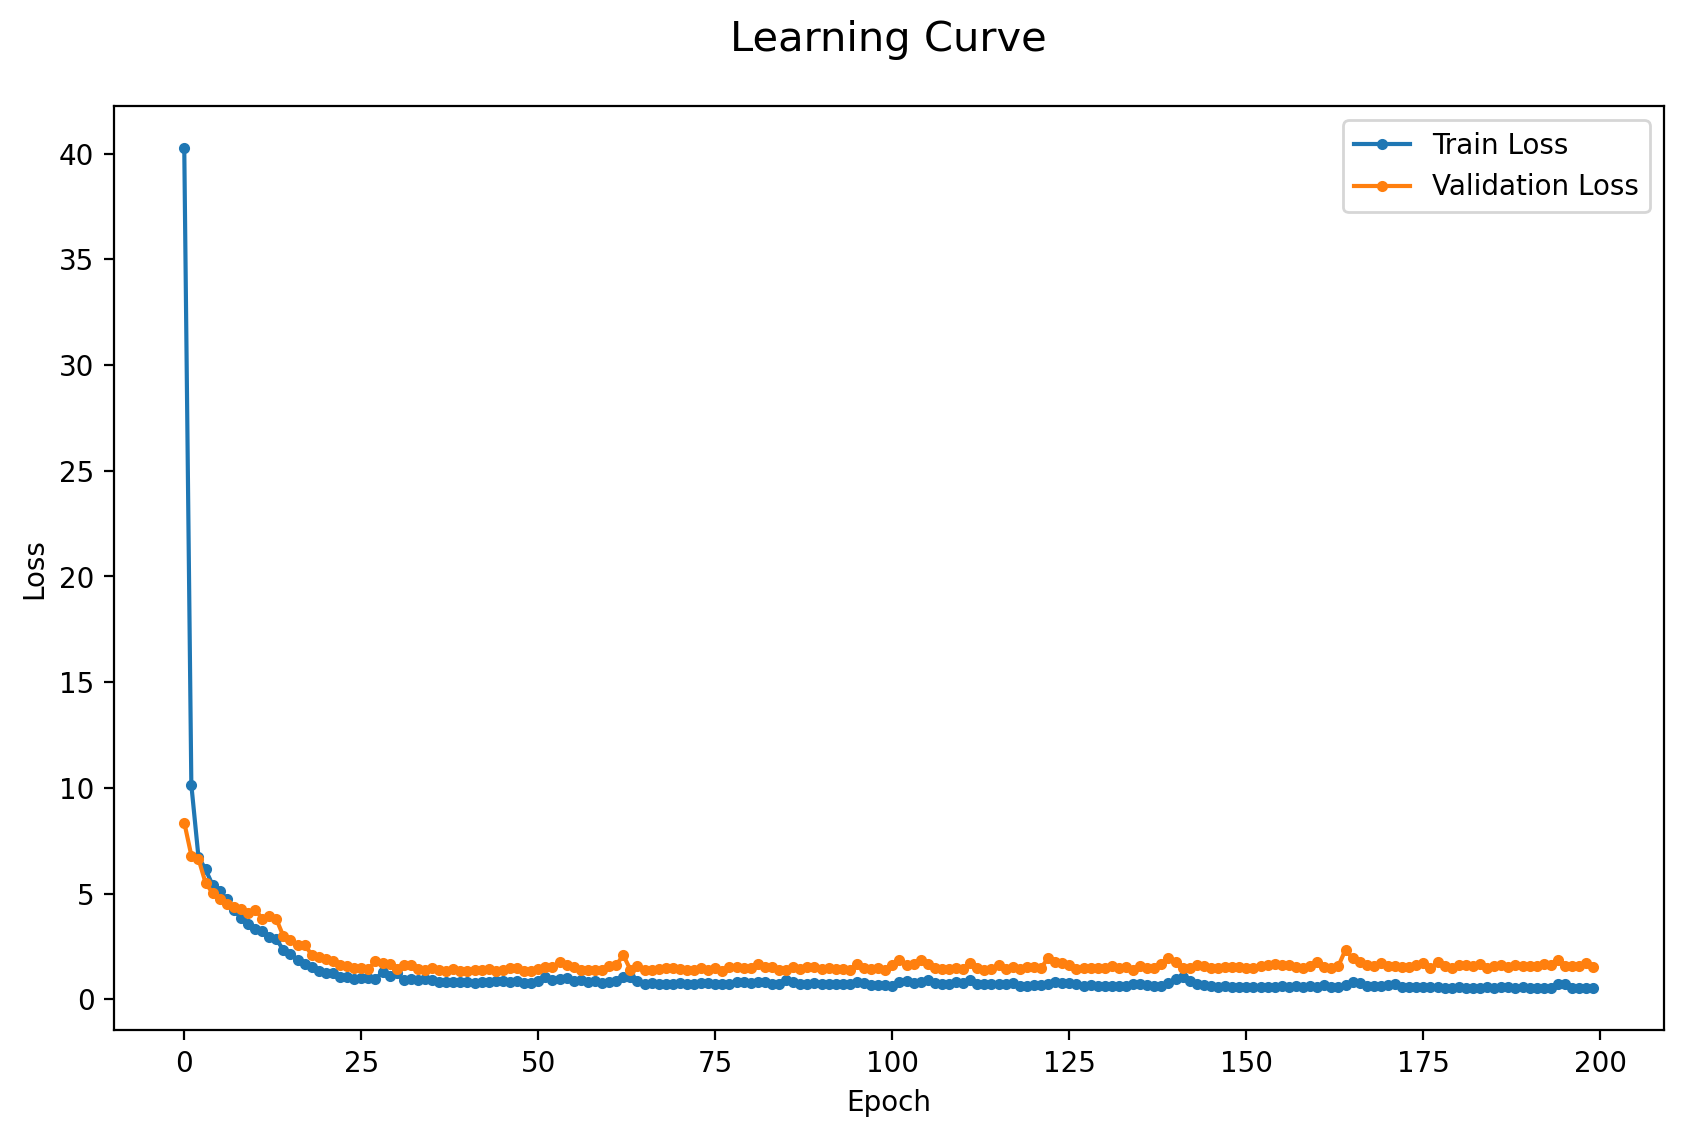

In [13]:
dl_history_plot(history)

### (2) 모델 2

#### 1) 모델 선언

- 일단 먼저 손으로 구조를 그려본 후 코드로 옮겨 봅니다.

In [24]:
model2 = Sequential([
    Input(shape=(nfeatures,)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])

model2.summary()
model2.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                │ (None, 128)            │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,777 (46.00 KB)

 Trainable params: 11,777 (46.00 KB)

 Non-trainable params: 0 (0.00 B)

#### 2) 모델 학습

In [ ]:
hist = model2.fit(x_train_scaled, y_train, epochs=200, validation_split=0.1, batch_size=32).history

Epoch 1/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 57.4829 - val_loss: 40.0603
Epoch 2/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 41.9956 - val_loss: 24.6418
Epoch 3/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 23.9180 - val_loss: 8.9785
Epoch 4/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 10.5695 - val_loss: 6.6625
Epoch 5/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 9.7337 - val_loss: 7.3141
Epoch 6/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 7.9740 - val_loss: 4.2276
Epoch 7/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 7.3141 - val_loss: 3.7298
Epoch 8/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.7389 - val_loss: 3.8447
Epoch 9/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 6.2719 - val_loss: 3.6386
Epoch 10/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 5.9406 - val_loss: 3.2347
Epoch 11/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 5.6695 - val_loss: 2.9687
Epoch 12/200
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 5.3629 - 

#### 3) 예측 및 성능 평가

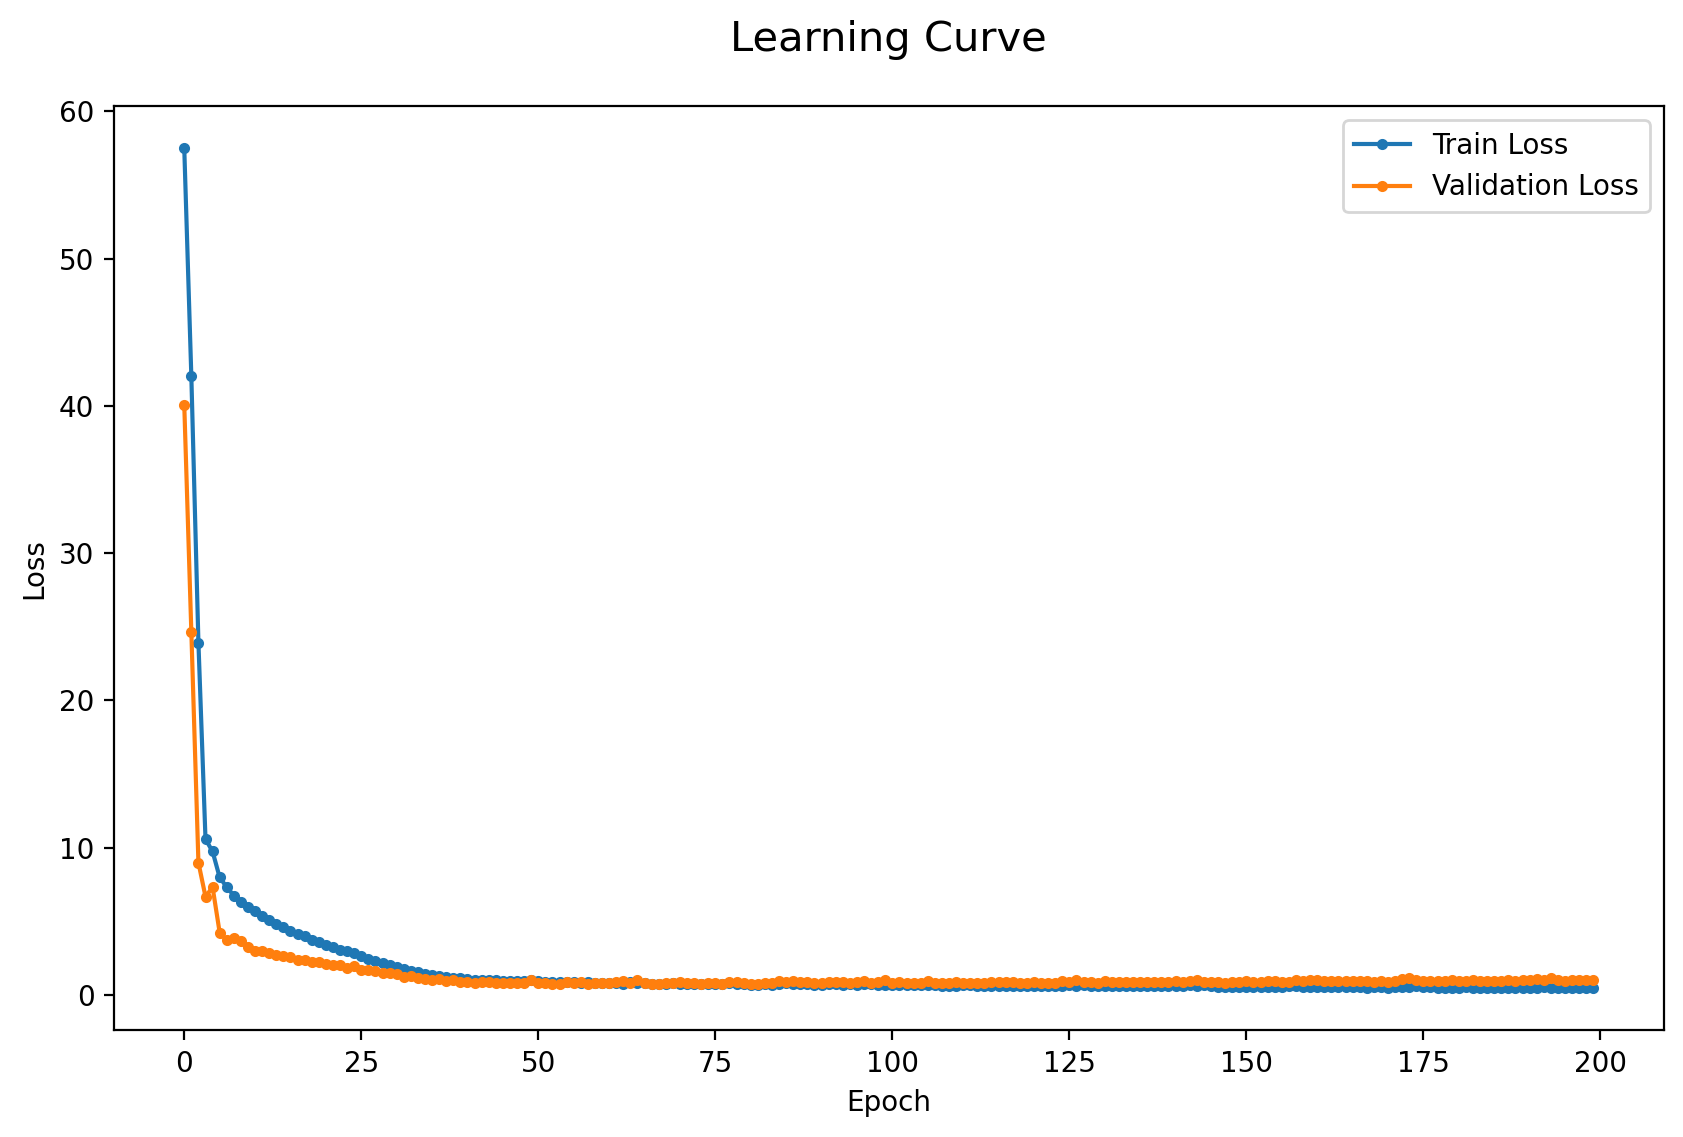

In [26]:
dl_history_plot(hist)

In [27]:
y_pred = model.predict(x_val_scaled)

# 성능 평가
print(f'* MAE: {mean_absolute_error(y_val, y_pred):.4f}')
print(f'* R² Score: {r2_score(y_val, y_pred):.4f}')


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
* MAE: 1.1484
* R² Score: 0.7672
